In [20]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from ResourceReservation import encode_float_filename

In [21]:
def getResults(direction,  mode, dbP, lenWindow, numAggregatedTraffic):
    dbpString = encode_float_filename(dbP)
    saveFolder = f"Results/MdpEvaluation/{direction}/{mode}_{dbpString}/{lenWindow}"
    with open(f"{saveFolder}/{lenWindow}_to_{numAggregatedTraffic}_simResultsMdp.pkl", "rb") as file:
        simResultsMdp = pickle.load(file)
    with open(f"{saveFolder}/{lenWindow}_to_{numAggregatedTraffic}_simResultsConst.pkl", "rb") as file:
        simResultsConst = pickle.load(file)
    with open(f"{saveFolder}/{lenWindow}_to_{numAggregatedTraffic}_simResultsNp.pkl", "rb") as file:
        simResultsNp = pickle.load(file)
    return simResultsMdp, simResultsConst, simResultsNp

def getMetrics(simResults):
    avgU = np.mean(simResults['simU_history'])
    avgAoS = np.mean(simResults['simAoS_history'])
    maxAoS = np.max(simResults['simAoS_history'])
    return avgU, avgAoS, maxAoS
 
def getBestMdpByUtilityOnWindowLen(lenWindow):
    direction = "forward"
    mode = "fixed"
    dbP = 0.02
    N_numAggregatedTraffic = 9
    bestUtilityMdp = []
    bestUtilityMdpValue = 0
    _, simResultsConst, simResultsNp = getResults(direction,  mode, dbP, lenWindow, 2)
    for numAggregatedTraffic in [int(x) for x in np.linspace(2, int(lenWindow/2), N_numAggregatedTraffic)]:
        simResultsMdp = getResults(direction,  mode, dbP, lenWindow, numAggregatedTraffic)[0]
        avgU = np.mean(simResultsMdp['simU_history'])
        if avgU > bestUtilityMdpValue:
            bestUtilityMdpValue = avgU
            bestUtilityMdp = simResultsMdp
            
    return bestUtilityMdp, simResultsConst, simResultsNp

In [22]:
avgUList = []
avgAoSList = []
maxAoSList = []
for lenWindow in [10, 20, 30]:
    simUtilityMdpBest, simResultsConst, simResultsNp = getBestMdpByUtilityOnWindowLen(lenWindow)

    avgUMdp, avgAoSMdp, maxAoSMdp = getMetrics(simUtilityMdpBest)
    avgUConst, avgAoSConst, maxAoSConst = getMetrics(simResultsConst)
    avgUNp, avgAoSNp, maxAoSNp = getMetrics(simResultsNp)
    avgUList.append([avgUConst, avgUNp, avgUMdp])
    avgAoSList.append([avgAoSConst, avgAoSNp, avgAoSMdp])
    maxAoSList.append([maxAoSConst, maxAoSNp, maxAoSMdp])

avgUList = np.array(avgUList)
avgAoSList = np.array(avgAoSList)
maxAoSList = np.array(maxAoSList)

print(np.array(avgUList))
print(np.array(maxAoSList))

[[0.98970212 0.992964   0.85121188]
 [0.9815143  0.98444455 0.90596135]
 [0.97186    0.97596785 0.81542808]]
[[15 15  3]
 [13 45  4]
 [26 73  6]]


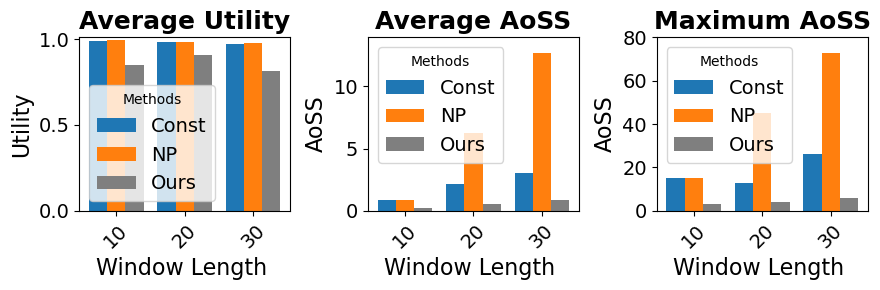

In [23]:

import numpy as np
import matplotlib.pyplot as plt

def plot_bar_chart(ax, data, categories=None, objects=None, title="Bar Chart", legendLoc="best", ylabel="value", fontsize=14):
    """
    Plots a bar chart on a given subplot (ax) with properly scaled y-axis.

    Parameters:
    - ax: The subplot axis to draw the bar chart on.
    - data: np.ndarray of shape (M, N), where M is the number of categories and N is the number of objects.
    - categories: List of category labels (length M).
    - objects: List of object labels (length N).
    - title: Title of the individual bar plot.
    """
    colorsTickets = ['#1f77b4', '#ff7f0e', '#7f7f7f']

    M, N = data.shape
    if categories is None:
        categories = [f"Category {i+1}" for i in range(M)]
    if objects is None:
        objects = [f"Object {j+1}" for j in range(N)]

    x = np.arange(M)  # Positions for categories
    width = 0.8 / N   # Width of each bar segment

    # Plot bars for each object in each category
    for j in range(N):
        ax.bar(x + j * width, data[:, j], width, label=objects[j], color=colorsTickets[j])

    ax.set_xlabel("Window Length ", fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize+2, fontweight='bold')
    ax.set_xticks(x + width * (N / 2 - 0.5))
    ax.set_xticklabels(categories, fontsize=fontsize-2, rotation=45)
    ax.legend(title="Methods", fontsize=fontsize-2, loc=legendLoc)

    # Set y-axis limit dynamically based on the data range
    y_min, y_max = data.min(), data.max()
    y_margin = (y_max - y_min) * 0.1  # 10% margin
    ax.set_ylim(0, y_max + y_margin)

def plot_combined_bar_charts(data_list, categories_list, objects_list, titles, ylabelList, fontsize=14):
    """
    Combines multiple bar plots into a single horizontal figure with individual y-axis limits.

    Parameters:
    - data_list: List of np.ndarray, each of shape (M, N).
    - categories_list: List of category label lists corresponding to each dataset.
    - objects_list: List of object label lists corresponding to each dataset.
    - titles: List of titles for each individual subplot.
    """
    num_plots = len(data_list)
    fig, axes = plt.subplots(1, num_plots, figsize=(3 * num_plots, 3))
    

    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot

    legendLocList = ["lower left", "best", "best"]
    for i, ax in enumerate(axes):
        plot_bar_chart(ax, data_list[i], categories_list[i], objects_list[i], titles[i], legendLocList[i], ylabelList[i], fontsize)
        ax.tick_params(axis='x', labelsize=fontsize-2)
        ax.tick_params(axis='y', labelsize=fontsize-2)

    plt.tight_layout()

    #plt.show()

categories = ["10", "20", "30"]
objects = ["Const", "NP", "Ours"]
titles = ["Average Utility", "Average AoSS", "Maximum AoSS"]
ylabelList = ["Utility", "AoSS", "AoSS"]

plot_combined_bar_charts([avgUList, avgAoSList, maxAoSList], [categories] * 3, [objects] * 3, titles, ylabelList,fontsize=16)
plt.savefig("Figures/sim04e_bestCompare.png", bbox_inches='tight', pad_inches=0.1, dpi=300) 


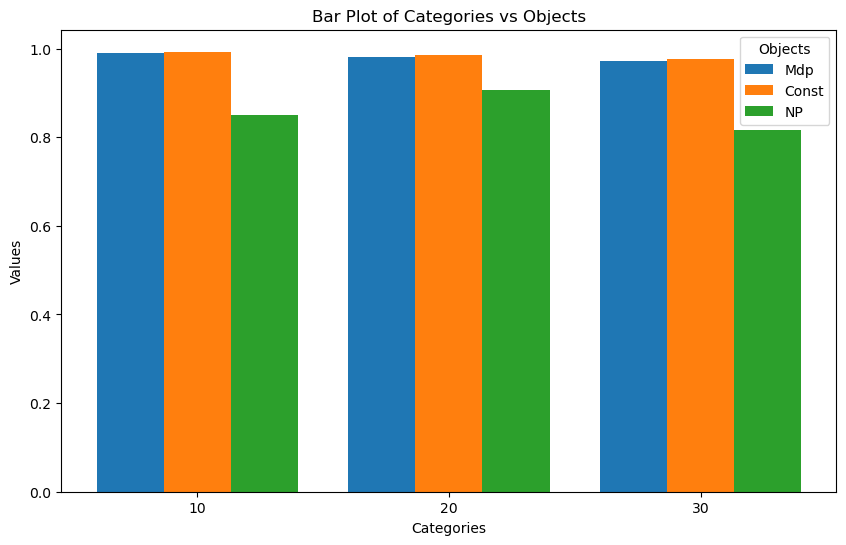

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def plot_bar_chart(data, categories=None, objects=None):
    """
    Plots a bar chart for a given MxN data matrix.

    Parameters:
    - data: np.ndarray of shape (M, N), where M is the number of categories and N is the number of objects.
    - categories: List of category labels (length M).
    - objects: List of object labels (length N).

    Returns:
    - A bar chart showing the values for each category and object.
    """
    data = np.array(data)
    M, N = data.shape
    if categories is None:
        categories = [f"Category {i+1}" for i in range(M)]
    if objects is None:
        objects = [f"Object {j+1}" for j in range(N)]

    x = np.arange(M)  # Positions for categories
    width = 0.8 / N   # Width of each bar segment

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars for each object in each category
    for j in range(N):
        ax.bar(x + j * width, data[:, j], width, label=objects[j])

    ax.set_xlabel("Categories")
    ax.set_ylabel("Values")
    ax.set_title("Bar Plot of Categories vs Objects")
    ax.set_xticks(x + width * (N / 2 - 0.5))
    ax.set_xticklabels(categories)
    ax.legend(title="Objects")

    plt.show()

# Example Usage:
data = np.array([[10, 15, 20], [5, 7, 12], [8, 10, 18]])
categories = ["10", "20", "30"]
methods = ["Mdp", "Const", "NP"]
plot_bar_chart(avgUList, categories, methods)